In [1]:
import logging

import probtorch
import torch

import combinators
import foldable
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_step = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=ssm_initializer)
ssm_sequence = foldable.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1))

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=init_ssm_generative)
ssm_generative = foldable.Reduce(ssm_step_generative, lambda: range(50))

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=init_ssm_proposal)
ssm_proposal = foldable.Reduce(ssm_step_proposal, lambda: range(50))

In [11]:
ssm_training = combinators.score_under_proposal(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_training, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

12/30/2018 22:15:29 ELBO=-5.57911682e+02 at epoch 1
12/30/2018 22:15:29 ELBO=-5.40371338e+02 at epoch 2
12/30/2018 22:15:29 ELBO=-5.94181152e+02 at epoch 3
12/30/2018 22:15:29 ELBO=-4.87259064e+02 at epoch 4
12/30/2018 22:15:29 ELBO=-3.43932434e+02 at epoch 5
12/30/2018 22:15:30 ELBO=-3.45146973e+02 at epoch 6
12/30/2018 22:15:30 ELBO=-2.38067963e+02 at epoch 7
12/30/2018 22:15:30 ELBO=-4.30966827e+02 at epoch 8
12/30/2018 22:15:30 ELBO=-3.18262970e+02 at epoch 9
12/30/2018 22:15:30 ELBO=-3.56163757e+02 at epoch 10
12/30/2018 22:15:30 ELBO=-4.31653717e+02 at epoch 11
12/30/2018 22:15:30 ELBO=-1.41523010e+02 at epoch 12
12/30/2018 22:15:30 ELBO=-2.82153046e+02 at epoch 13
12/30/2018 22:15:30 ELBO=-1.81829132e+02 at epoch 14
12/30/2018 22:15:30 ELBO=-5.53822998e+02 at epoch 15
12/30/2018 22:15:30 ELBO=-2.51944763e+02 at epoch 16
12/30/2018 22:15:30 ELBO=-2.82803406e+02 at epoch 17
12/30/2018 22:15:30 ELBO=-2.77562744e+02 at epoch 18
12/30/2018 22:15:31 ELBO=-4.53879364e+02 at epoch 19
12

Epoch   112: reducing learning rate of group 0 to 5.0000e-03.


12/30/2018 22:15:39 ELBO=-2.14357468e+02 at epoch 116
12/30/2018 22:15:39 ELBO=-2.50537247e+02 at epoch 117
12/30/2018 22:15:39 ELBO=-2.77015747e+02 at epoch 118
12/30/2018 22:15:39 ELBO=-2.16428314e+02 at epoch 119
12/30/2018 22:15:39 ELBO=-2.22487656e+02 at epoch 120
12/30/2018 22:15:39 ELBO=-1.96383667e+02 at epoch 121
12/30/2018 22:15:39 ELBO=-2.06685638e+02 at epoch 122
12/30/2018 22:15:39 ELBO=-3.11705444e+02 at epoch 123
12/30/2018 22:15:39 ELBO=-3.93055725e+02 at epoch 124
12/30/2018 22:15:39 ELBO=-2.69448669e+02 at epoch 125
12/30/2018 22:15:39 ELBO=-1.81202057e+02 at epoch 126
12/30/2018 22:15:40 ELBO=-2.39854279e+02 at epoch 127
12/30/2018 22:15:40 ELBO=-2.66332428e+02 at epoch 128
12/30/2018 22:15:40 ELBO=-2.94224731e+02 at epoch 129
12/30/2018 22:15:40 ELBO=-2.31428131e+02 at epoch 130
12/30/2018 22:15:40 ELBO=-2.81841888e+02 at epoch 131
12/30/2018 22:15:40 ELBO=-2.18922592e+02 at epoch 132
12/30/2018 22:15:40 ELBO=-2.64352356e+02 at epoch 133
12/30/2018 22:15:40 ELBO=-2.

Epoch   213: reducing learning rate of group 0 to 2.5000e-03.


12/30/2018 22:15:47 ELBO=-2.39774353e+02 at epoch 217
12/30/2018 22:15:47 ELBO=-2.88492432e+02 at epoch 218
12/30/2018 22:15:47 ELBO=-2.11415558e+02 at epoch 219
12/30/2018 22:15:47 ELBO=-2.64305054e+02 at epoch 220
12/30/2018 22:15:47 ELBO=-1.85487152e+02 at epoch 221
12/30/2018 22:15:47 ELBO=-3.34961151e+02 at epoch 222
12/30/2018 22:15:47 ELBO=-3.25395386e+02 at epoch 223
12/30/2018 22:15:48 ELBO=-1.67756683e+02 at epoch 224
12/30/2018 22:15:48 ELBO=-2.59876648e+02 at epoch 225
12/30/2018 22:15:48 ELBO=-2.88138123e+02 at epoch 226
12/30/2018 22:15:48 ELBO=-3.55002563e+02 at epoch 227
12/30/2018 22:15:48 ELBO=-2.38067780e+02 at epoch 228
12/30/2018 22:15:48 ELBO=-1.81575958e+02 at epoch 229
12/30/2018 22:15:48 ELBO=-2.99313660e+02 at epoch 230
12/30/2018 22:15:48 ELBO=-3.04940277e+02 at epoch 231
12/30/2018 22:15:48 ELBO=-1.88624817e+02 at epoch 232
12/30/2018 22:15:48 ELBO=-2.80111481e+02 at epoch 233
12/30/2018 22:15:48 ELBO=-2.23611298e+02 at epoch 234
12/30/2018 22:15:48 ELBO=-3.

Epoch   366: reducing learning rate of group 0 to 1.2500e-03.


12/30/2018 22:16:01 ELBO=-1.98543716e+02 at epoch 370
12/30/2018 22:16:01 ELBO=-2.21685852e+02 at epoch 371
12/30/2018 22:16:01 ELBO=-2.57021698e+02 at epoch 372
12/30/2018 22:16:01 ELBO=-2.40621902e+02 at epoch 373
12/30/2018 22:16:01 ELBO=-2.66971558e+02 at epoch 374
12/30/2018 22:16:01 ELBO=-2.43826904e+02 at epoch 375
12/30/2018 22:16:01 ELBO=-1.60382477e+02 at epoch 376
12/30/2018 22:16:01 ELBO=-1.50548401e+02 at epoch 377
12/30/2018 22:16:01 ELBO=-2.33984528e+02 at epoch 378
12/30/2018 22:16:02 ELBO=-1.97783203e+02 at epoch 379
12/30/2018 22:16:02 ELBO=-3.66227356e+02 at epoch 380
12/30/2018 22:16:02 ELBO=-3.07426788e+02 at epoch 381
12/30/2018 22:16:02 ELBO=-2.66097198e+02 at epoch 382
12/30/2018 22:16:02 ELBO=-2.36684723e+02 at epoch 383
12/30/2018 22:16:02 ELBO=-2.62206726e+02 at epoch 384
12/30/2018 22:16:02 ELBO=-1.99682999e+02 at epoch 385
12/30/2018 22:16:02 ELBO=-2.57647736e+02 at epoch 386
12/30/2018 22:16:02 ELBO=-2.68460358e+02 at epoch 387
12/30/2018 22:16:02 ELBO=-4.

Epoch   515: reducing learning rate of group 0 to 6.2500e-04.


12/30/2018 22:16:14 ELBO=-2.15287598e+02 at epoch 519
12/30/2018 22:16:14 ELBO=-2.98242310e+02 at epoch 520
12/30/2018 22:16:14 ELBO=-2.57512207e+02 at epoch 521
12/30/2018 22:16:14 ELBO=-1.99307693e+02 at epoch 522
12/30/2018 22:16:14 ELBO=-2.32018921e+02 at epoch 523
12/30/2018 22:16:14 ELBO=-2.28619568e+02 at epoch 524
12/30/2018 22:16:14 ELBO=-2.14778656e+02 at epoch 525
12/30/2018 22:16:14 ELBO=-2.71515503e+02 at epoch 526
12/30/2018 22:16:14 ELBO=-2.30689194e+02 at epoch 527
12/30/2018 22:16:14 ELBO=-3.20358002e+02 at epoch 528
12/30/2018 22:16:15 ELBO=-2.70126831e+02 at epoch 529
12/30/2018 22:16:15 ELBO=-3.03060120e+02 at epoch 530
12/30/2018 22:16:15 ELBO=-2.02828262e+02 at epoch 531
12/30/2018 22:16:15 ELBO=-1.97226349e+02 at epoch 532
12/30/2018 22:16:15 ELBO=-2.60753479e+02 at epoch 533
12/30/2018 22:16:15 ELBO=-3.83024109e+02 at epoch 534
12/30/2018 22:16:15 ELBO=-2.57101105e+02 at epoch 535
12/30/2018 22:16:15 ELBO=-2.26559326e+02 at epoch 536
12/30/2018 22:16:15 ELBO=-2.

Epoch   616: reducing learning rate of group 0 to 3.1250e-04.


12/30/2018 22:16:22 ELBO=-2.64226807e+02 at epoch 620
12/30/2018 22:16:23 ELBO=-1.98553528e+02 at epoch 621
12/30/2018 22:16:23 ELBO=-4.34558746e+02 at epoch 622
12/30/2018 22:16:23 ELBO=-2.73371094e+02 at epoch 623
12/30/2018 22:16:23 ELBO=-2.28764893e+02 at epoch 624
12/30/2018 22:16:23 ELBO=-2.31474762e+02 at epoch 625
12/30/2018 22:16:23 ELBO=-1.60598114e+02 at epoch 626
12/30/2018 22:16:23 ELBO=-2.44942627e+02 at epoch 627
12/30/2018 22:16:23 ELBO=-2.70246765e+02 at epoch 628
12/30/2018 22:16:23 ELBO=-2.31017090e+02 at epoch 629
12/30/2018 22:16:23 ELBO=-1.91785980e+02 at epoch 630
12/30/2018 22:16:23 ELBO=-2.36199341e+02 at epoch 631
12/30/2018 22:16:23 ELBO=-1.67771851e+02 at epoch 632
12/30/2018 22:16:23 ELBO=-1.97977173e+02 at epoch 633
12/30/2018 22:16:24 ELBO=-2.40347092e+02 at epoch 634
12/30/2018 22:16:24 ELBO=-2.08187881e+02 at epoch 635
12/30/2018 22:16:24 ELBO=-2.08511749e+02 at epoch 636
12/30/2018 22:16:24 ELBO=-1.97396912e+02 at epoch 637
12/30/2018 22:16:24 ELBO=-2.

Epoch   717: reducing learning rate of group 0 to 1.5625e-04.


12/30/2018 22:16:31 ELBO=-3.50224121e+02 at epoch 721
12/30/2018 22:16:31 ELBO=-2.21906342e+02 at epoch 722
12/30/2018 22:16:31 ELBO=-1.64902679e+02 at epoch 723
12/30/2018 22:16:31 ELBO=-2.17323364e+02 at epoch 724
12/30/2018 22:16:31 ELBO=-2.19887466e+02 at epoch 725
12/30/2018 22:16:31 ELBO=-3.05396606e+02 at epoch 726
12/30/2018 22:16:31 ELBO=-2.68359924e+02 at epoch 727
12/30/2018 22:16:31 ELBO=-1.58746811e+02 at epoch 728
12/30/2018 22:16:31 ELBO=-2.02507797e+02 at epoch 729
12/30/2018 22:16:32 ELBO=-1.45079895e+02 at epoch 730
12/30/2018 22:16:32 ELBO=-1.58487274e+02 at epoch 731
12/30/2018 22:16:32 ELBO=-2.70071838e+02 at epoch 732
12/30/2018 22:16:32 ELBO=-1.89196594e+02 at epoch 733
12/30/2018 22:16:32 ELBO=-1.95095825e+02 at epoch 734
12/30/2018 22:16:32 ELBO=-1.92095566e+02 at epoch 735
12/30/2018 22:16:32 ELBO=-1.63998795e+02 at epoch 736
12/30/2018 22:16:32 ELBO=-2.47588440e+02 at epoch 737
12/30/2018 22:16:32 ELBO=-2.24572632e+02 at epoch 738
12/30/2018 22:16:32 ELBO=-1.

Epoch   818: reducing learning rate of group 0 to 7.8125e-05.


12/30/2018 22:16:39 ELBO=-3.05709015e+02 at epoch 822
12/30/2018 22:16:39 ELBO=-2.08857025e+02 at epoch 823
12/30/2018 22:16:39 ELBO=-1.80843063e+02 at epoch 824
12/30/2018 22:16:40 ELBO=-1.42920166e+02 at epoch 825
12/30/2018 22:16:40 ELBO=-3.01285522e+02 at epoch 826
12/30/2018 22:16:40 ELBO=-2.15630615e+02 at epoch 827
12/30/2018 22:16:40 ELBO=-2.82251556e+02 at epoch 828
12/30/2018 22:16:40 ELBO=-2.37123016e+02 at epoch 829
12/30/2018 22:16:40 ELBO=-2.49946243e+02 at epoch 830
12/30/2018 22:16:40 ELBO=-1.76095673e+02 at epoch 831
12/30/2018 22:16:40 ELBO=-2.42399994e+02 at epoch 832
12/30/2018 22:16:40 ELBO=-2.24184174e+02 at epoch 833
12/30/2018 22:16:40 ELBO=-1.74231110e+02 at epoch 834
12/30/2018 22:16:40 ELBO=-1.44797058e+02 at epoch 835
12/30/2018 22:16:40 ELBO=-1.80845932e+02 at epoch 836
12/30/2018 22:16:41 ELBO=-4.17366425e+02 at epoch 837
12/30/2018 22:16:41 ELBO=-1.43941910e+02 at epoch 838
12/30/2018 22:16:41 ELBO=-2.73417236e+02 at epoch 839
12/30/2018 22:16:41 ELBO=-2.

Epoch   919: reducing learning rate of group 0 to 3.9063e-05.


12/30/2018 22:16:48 ELBO=-2.21685211e+02 at epoch 923
12/30/2018 22:16:48 ELBO=-2.36936432e+02 at epoch 924
12/30/2018 22:16:48 ELBO=-2.74002441e+02 at epoch 925
12/30/2018 22:16:48 ELBO=-2.12244797e+02 at epoch 926
12/30/2018 22:16:48 ELBO=-1.90143677e+02 at epoch 927
12/30/2018 22:16:48 ELBO=-1.47707382e+02 at epoch 928
12/30/2018 22:16:48 ELBO=-2.45936371e+02 at epoch 929
12/30/2018 22:16:48 ELBO=-1.80265961e+02 at epoch 930
12/30/2018 22:16:48 ELBO=-1.95016815e+02 at epoch 931
12/30/2018 22:16:49 ELBO=-2.08098282e+02 at epoch 932
12/30/2018 22:16:49 ELBO=-1.74413818e+02 at epoch 933
12/30/2018 22:16:49 ELBO=-1.74432129e+02 at epoch 934
12/30/2018 22:16:49 ELBO=-2.99177887e+02 at epoch 935
12/30/2018 22:16:49 ELBO=-1.83565857e+02 at epoch 936
12/30/2018 22:16:49 ELBO=-1.59783936e+02 at epoch 937
12/30/2018 22:16:49 ELBO=-1.63899277e+02 at epoch 938
12/30/2018 22:16:49 ELBO=-1.73527527e+02 at epoch 939
12/30/2018 22:16:49 ELBO=-1.86154404e+02 at epoch 940
12/30/2018 22:16:49 ELBO=-2.

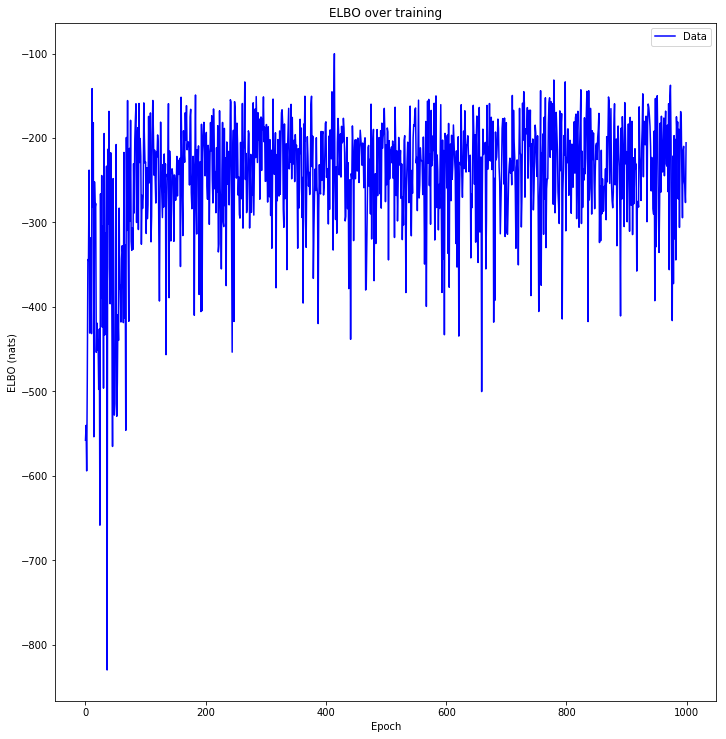

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
ssm_smc = importance.reduce_smc(combinators.PrimitiveCall(ssm.ssm_step), particle_shape, lambda: range(50), initializer=init_ssm_proposal)
ssm_score = combinators.score_under_proposal(ssm_smc, ssm_generative)

In [15]:
_, inference = ssm_score(data=data)

In [16]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 1.852831
SMC MSE at time 2: 0.694824
SMC MSE at time 3: 1.944749
SMC MSE at time 4: 0.524067
SMC MSE at time 5: 0.666002
SMC MSE at time 6: 0.850774
SMC MSE at time 7: 1.275152
SMC MSE at time 8: 0.759779
SMC MSE at time 9: 2.964082
SMC MSE at time 10: 1.225881
SMC MSE at time 11: 0.405939
SMC MSE at time 12: 1.148626
SMC MSE at time 13: 0.808350
SMC MSE at time 14: 1.081885
SMC MSE at time 15: 0.524982
SMC MSE at time 16: 0.514783
SMC MSE at time 17: 0.866716
SMC MSE at time 18: 0.737450
SMC MSE at time 19: 1.241805
SMC MSE at time 20: 1.517256
SMC MSE at time 21: 2.551304
SMC MSE at time 22: 1.232788
SMC MSE at time 23: 0.870047
SMC MSE at time 24: 0.408342
SMC MSE at time 25: 0.548251
SMC MSE at time 26: 0.985285
SMC MSE at time 27: 0.728475
SMC MSE at time 28: 0.664174
SMC MSE at time 29: 1.129555
SMC MSE at time 30: 2.001484
SMC MSE at time 31: 1.152020
SMC MSE at time 32: 0.776496
SMC MSE at time 33: 0.547504
SMC MSE at time 34: 0.539312
SMC MSE at time 35: 1.1

In [17]:
particle_mh = mcmc.LightweightMH(ssm_score, moves=100)

In [18]:
lookup = utils.dict_lookup(data)
samples, inference = particle_mh(data=data, trace=inference)

In [19]:
inference

In [20]:
generative

In [21]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 1.741967
SMC MSE at time 2: 0.066530
SMC MSE at time 3: 2.532824
SMC MSE at time 4: 0.831911
SMC MSE at time 5: 2.132698
SMC MSE at time 6: 0.564043
SMC MSE at time 7: 0.635654
SMC MSE at time 8: 1.331665
SMC MSE at time 9: 3.762546
SMC MSE at time 10: 0.422298
SMC MSE at time 11: 0.162359
SMC MSE at time 12: 0.686501
SMC MSE at time 13: 0.010539
SMC MSE at time 14: 0.216000
SMC MSE at time 15: 0.321456
SMC MSE at time 16: 0.147454
SMC MSE at time 17: 0.106519
SMC MSE at time 18: 0.558543
SMC MSE at time 19: 0.227922
SMC MSE at time 20: 2.743306
SMC MSE at time 21: 1.746465
SMC MSE at time 22: 0.338968
SMC MSE at time 23: 2.208637
SMC MSE at time 24: 0.250874
SMC MSE at time 25: 0.118330
SMC MSE at time 26: 0.960232
SMC MSE at time 27: 0.004649
SMC MSE at time 28: 0.328790
SMC MSE at time 29: 0.519943
SMC MSE at time 30: 1.381017
SMC MSE at time 31: 0.338578
SMC MSE at time 32: 0.243668
SMC MSE at time 33: 1.590683
SMC MSE at time 34: 0.076679
SMC MSE at time 35: 0.2

In [22]:
init_ssm_params

"{'first.folder._initializer.delta__loc': 'tensor(0.3601)', 'first.folder._initializer.delta__scale': 'tensor(0.4177)', 'first.folder._initializer.mu__loc': 'tensor(-0.2792)', 'first.folder._initializer.mu__scale': 'tensor(0.2506)', 'first.folder._initializer.sigma__loc': 'tensor(0.6810)', 'first.folder._initializer.sigma__scale': 'tensor(0.1076)', 'second.sampler.folder._initializer.delta__loc': 'tensor(0.)', 'second.sampler.folder._initializer.delta__scale': 'tensor(0.2500)', 'second.sampler.folder._initializer.mu__loc': 'tensor(0.)', 'second.sampler.folder._initializer.mu__scale': 'tensor(0.2500)', 'second.sampler.folder._initializer.sigma__loc': 'tensor(1.)', 'second.sampler.folder._initializer.sigma__scale': 'tensor(0.2500)'}"